### The Probability Integral Transform

Let  {$f_t(y_t | \Omega_t)$}$_{t=1}^m$ be a data generating process where $\Omega_t =$ {$y_{t-1}, y_{t -2}, ...$}. <br>
$f_t(y_t|\Omega_t)$ is the density of $y_t$ based on past observations <br>
Let {$p_t(y_t | \Omega_t)$}$_{t=1}^m$ be a sequence of density forecasts of $y_t$ <br>
One can relate the data generated from $f$ and sequence of density forecasts through the probability integral transform, $z_t$: <br>
$$z_t = \int_{-\infty}^{y_t} p_t(u) du = P_t(y_t)$$


Suppose {$y_t$}$_{t=1}^m$ is generated from {$f_t(y_t | \Omega_t)$}$_{t=1}^m$. If a sequence of density forecasts {$p_t(y_t | \Omega_t)$}$_{t=1}^m$ coincides with {$f_t(y_t | \Omega_t)$}$_{t=1}^m$, then the sequence of probability integral transforms of {$y_t$}$_{t=1}^m$ with respect to {$p_t(y_t | \Omega_t)$}$_{t=1}^m$ is iid U(0, 1) (independent and identically distributed coming from a uniform distribution on the interval (0, 1))<br>

Let's start with a simple example. Let's assume we have a time series where the increments are normally distributed, $N$(0, 1)

In [8]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

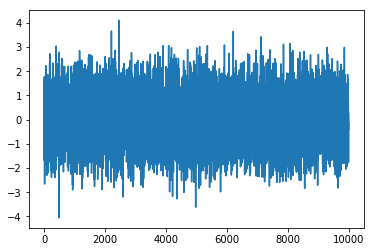

In [17]:
# Generate a realization of a time series with Gaussian increments
m = 10000  # number of points in single realization of a time series
yt = np.random.normal(size=m)  # Gaussian data with mean=0 and sigma=1
plt.plot(yt)
plt.show()

For each point, $y$, in the timeseries, we need to calculate its Probability Integral Transform. This means that, for every value of $y$, we must integrate our assumed probability density from -$\infty$ to $y$. This is the same information we can get from a cumulative density function (CDF). <br>
<br>
Even though we know that we generated the data by pulling from $N(0, 1)$ distribution, let's see what happens if we assume a different distribution. <br>
<br>
Start by checking if this data is well-described by a cauchy distribution.

In [20]:
from scipy.stats import cauchy

zt = cauchy.cdf(yt)  # integrated probability up to each point

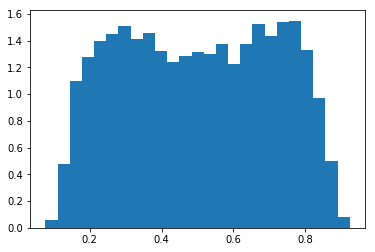

In [21]:
# If cauchy is the correct distribution, then a histogram of the values of zt should be
# uniform

plt.hist(zt, bins=25, density=True)
plt.show()

Nope. Not uniform, cauchy probably isn't the right distribution. We are missing information from the tails. Now try Gaussian.

In [23]:
from scipy.stats import norm

zt = norm.cdf(yt)

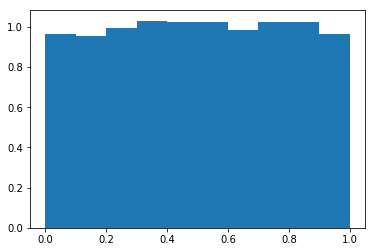

In [24]:
# If we assumed the probability density above (Gaussian) then a histogram of zt values
# should be uniform.
plt.hist(zt, density=True)
plt.show()

That's better. 

Now, let's work through the examples of Diebold, Gunther and Tay (see [their paper](https://www.sas.upenn.edu/~fdiebold/papers/paper16/paper16.pdf))

The generalized autoregressive conditional heteroskedasticity (GARCH) process is an approach to esimate the volatility of financial markets. The authors use a GARCH(1,1) data generating process. In a GARCH($p$,$q$) process, the variance, $h_t$ is given by
$$h_t = \omega + \sum_{i=1}^q \alpha_i y_{t-i}^2 + \sum_{i=1}^p \beta_i h_{t-i}$$
So for a GARCH(1, 1) process, we have:
$$h_t = \omega + \alpha y_{t-1}^2 + \beta h_{t-1}$$
<br>
The conditional density of the process is a standardized Student's-t with six degrees of freedom,
$$y_t = \sqrt{\dfrac{2h_t}{3}}t(6)$$

The authors use values of $\omega = 0.01$, $\alpha = 0.13$ and $\beta = 0.86$. <br>

<br>
It has been [suggested](https://stats.stackexchange.com/questions/133286/initial-value-of-the-conditional-variance-in-the-garch-process) that one can initialize the process by setting $h_t$ equal the sample variance.

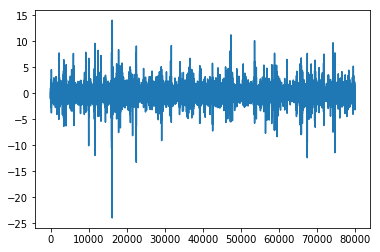

In [226]:
# generate and plot a GARCH(1,1) time series
n = 80000 # number of points in timeseries
ht0 = 1  # initialize h_t-1 with the expected variance

w = 0.01
alpha = 0.13
beta = 0.86

ht = np.zeros([n])
yt = np.zeros([n])

ht[0] = ht0
yt[0] = np.sqrt(2*ht0/3)*np.random.standard_t(6)

for t in range(1, n):
    ht[t] = w + alpha * yt[t - 1]**2 + beta * ht[t - 1]
    yt[t] = np.sqrt(2*ht[t]/3)*np.random.standard_t(6)
    
plt.plot(yt)
plt.show()

The authors use the first half of the data as 'in-sample' observations for estimation of the probability density. The second half, or 'out-of-sample' observations, are used for density forecast evaluation. <br>
<br>
Since we are using a conditional density (i.e. it depends on its previous value(s)), we will perform the Probability Integral Transform using an emperical cumulative distribution (ecdf) generated from the in-sample observations. A class to generate ecdfs is defined below.

In [268]:
class Cdf(object):  # taken from compare_disorder.py

    def __init__(self, data):
        """
        Generate an emperical cumulative distribution function from data
        :param data: x-values of data in no particular order
        """

        self.xs = np.array(sorted(data))
        self.N = float(len(self.xs))
        self.ys = np.arange(1, self.N + 1) / self.N

    def cdf(self, x):
        """
        Callable cumulative emperical distribution function
        :param x: array of x-values at which to evaluate cumulative emperical distribution function
        :return:
        """
        if type(x) is np.float64:
            x = np.array([x])
    
        ndx = [np.argmin(np.abs(self.xs - x[i])) for i in range(x.size)]

        return self.ys[ndx]

    def random_sample(self, n=1):
        """
        :param n: number of random samples to draw (default=1)
        :return: random samples
        """

        return np.random.choice(self.xs, size=n, replace=True)
    
    def update_cdf(self, obs):
        """ Add observation to the cdf (only works for single value right now)
        """
        
        self.xs = sorted(np.concatenate((self.xs, [obs])))
        self.N = float(len(self.xs))
        self.ys = np.arange(1, self.N + 1) / self.N
        
        

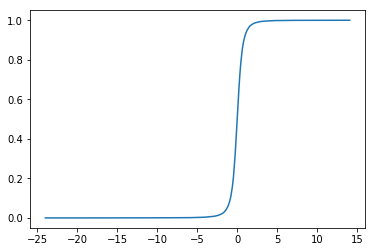

In [228]:
# generate an empirical cumulative distribution function from data
insample = yt[:n//2]
outsample = yt[n//2:]
ecdf = Cdf(insample)
plt.plot(ecdf.xs, ecdf.ys)
plt.show()

Start by establishing a benchmark by assuming, incorrectly, that the density forecast for the process is iid N(0, 1). For each of the periods 40001 - 80000, we will issue the forecast N(0, 1).

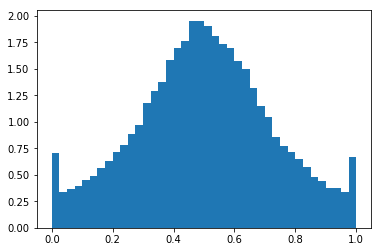

In [230]:
# forecast using a gaussian density
zt = norm.cdf(outsample)
plt.hist(zt, bins=40, density=True)
plt.show()

Clearly the distribution above is not uniform. Therefore, a Gaussian process cannot appropriately describe the timeseries. The distribution that we just obtained shows a peak in the middle with two 'wings' on either side meaning that too many realizations fell in the middle and in the tails of forecast densities relative to what we'd expect if the data were really iid normal. We can visualize this point by looking at the CDFs of our data and that of a normal distribution. (Note that this qualitative behavior might not perfectly hold for a given realization of the GARCH process, especially if n is low. If the above plot is not consistent with this explanation, try to regenerate the time series and/or use more data points)

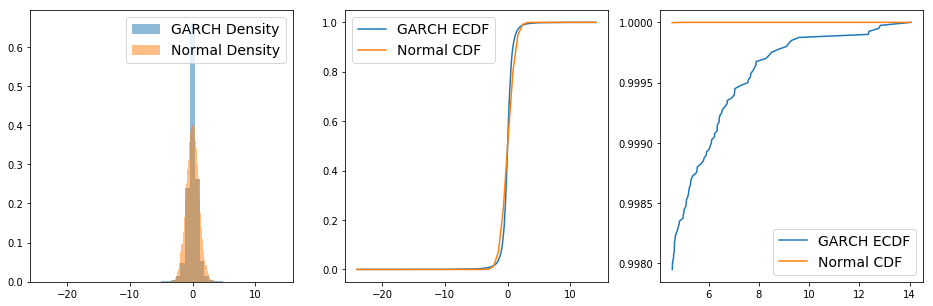

In [234]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))  # initialize row of 3 plots

# Plot Densities
bins = 50
ax[0].hist(yt, bins=bins, alpha=0.5, label='GARCH Density', density=True)
ax[0].hist(np.random.normal(size=yt.size), bins=bins, alpha=0.5, density=True, label='Normal Density')
ax[0].legend(fontsize=14)

# Plot the cdfs on top of each other
ax[1].plot(ecdf.xs, ecdf.ys, label='GARCH ECDF')
rang = np.linspace(min(ecdf.xs), max(ecdf.xs))
ax[1].plot(rang, norm.cdf(rang), label='Normal CDF')
ax[1].legend(fontsize=14)

# zoom on the right tail of the CDFs
start_value = min(ecdf.xs) + (max(ecdf.xs) - min(ecdf.xs)) * .75
ecdf_start = np.argmin(np.abs(ecdf.xs - start_value))

right_tail = np.linspace(start_value, max(ecdf.xs))
ax[2].plot(ecdf.xs[ecdf_start:], ecdf.ys[ecdf_start:], label='GARCH ECDF')
ax[2].plot(right_tail, norm.cdf(right_tail), label='Normal CDF')
ax[2].legend(fontsize=14)

plt.show()

Compared to the Normal density, the GARCH density is heavy tailed, with a narrower distribution about its mean. Since we assumed the density forecast to be Gaussian, we observe hump at the center of the distribution of $z$ due to oversampling near zero caused by the narrow peak of the in-sample ECDF. Since the in-sample ECDF is also heavy tailed, wings appear near 0 and 1 in the $z$ distribution because the tails are also oversampled by the out-of-sample data.

Besides looking for uniformity in the distribution of $z$ values, another useful tool for evaluating density forecasts are correlograms of $(z - \overline{z})$, $(z - \overline{z})^2$, $(z - \overline{z})^3$, $(z - \overline{z})^4$ which reveal the dependence of the conditional mean, conditional variance, conditional skewness and conditional kurtosis respectively. Diebold et al. claims these powers of $(z-\overline{z})$ are adequate when searching for potentially sophisticated nonlinear forms of dependence. Below, we plot each of the correlograms.

In [263]:
# Initialize a 2x2 figure
from LLC_Membranes.llclib import timeseries

def correlograms(z):
    
    """ Plot correlograms of (z - zmean), (z - zmean)^2, (z - zmean)^3, (z - zmean)^4
    :param z: timeseries of probability integral transforms
    """
    # Initialize a 2x2 figure
    fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

    stop = 200  # index of point at which to stop (Diebold et al. stopped at 200)

    ax[0, 0].plot(timeseries.acf(zt - zt.mean())[:stop], linewidth=2) # (z - meanz)
    ax[0, 1].plot(timeseries.acf((zt - zt.mean())**2)[:stop], linewidth=2) # (z - meanz)^2
    ax[1, 0].plot(timeseries.acf((zt - zt.mean())**3)[:stop], linewidth=2) # (z - meanz)^2
    ax[1, 1].plot(timeseries.acf((zt - zt.mean())**4)[:stop], linewidth=2) # (z - meanz)^2

    titles = ['$(z - \overline{z})$', '$(z - \overline{z})^2$', '$(z - \overline{z})^3$', '$(z - \overline{z})^4$']

    for i in range(4):
        ax[i // 2, i % 2].set_title(titles[i], fontsize=14)
        ax[i // 2, i % 2].tick_params(labelsize=14)

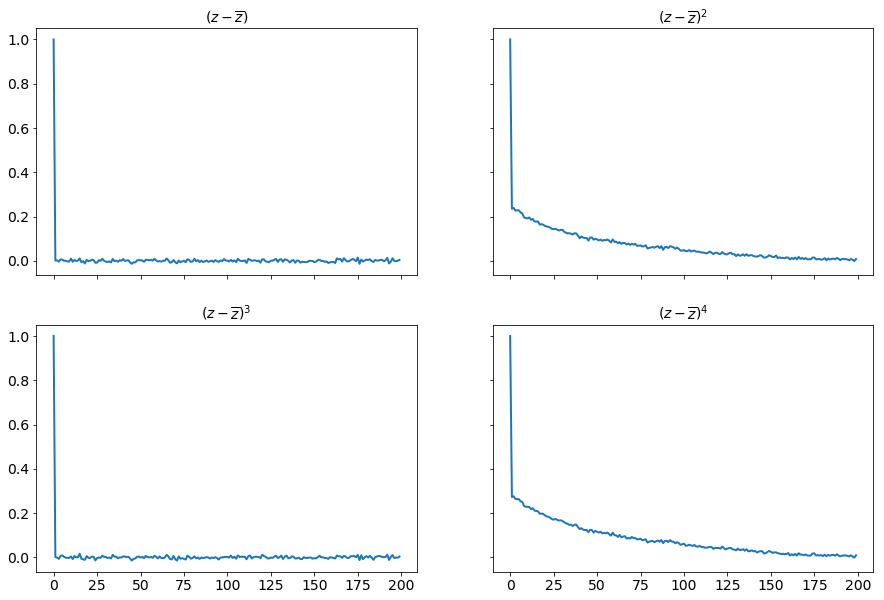

In [265]:
# Generate and plot correlograms
correlograms(zt)
plt.show()

There is strong serial correlation of $(z - \overline{z})^2$ and $(z - \overline{z})^4$ which highlights a second failure of the N(0, 1) forecast.

Next, Diebold et al. evaluate the process as if it were still t-distribution, but without any conditional dependence. This means that we should estimate the conditional distribution from the insample data, freeze it, and then use it as the unchanging density forecast for the outsample data.

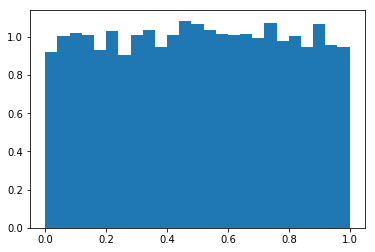

In [266]:
zt = ecdf.cdf(outsample)  # use non-conditional distribution to 
plt.hist(zt, bins=25, density=True)
plt.show()

The $z$ distribution looks uniform. But what about the correlograms?

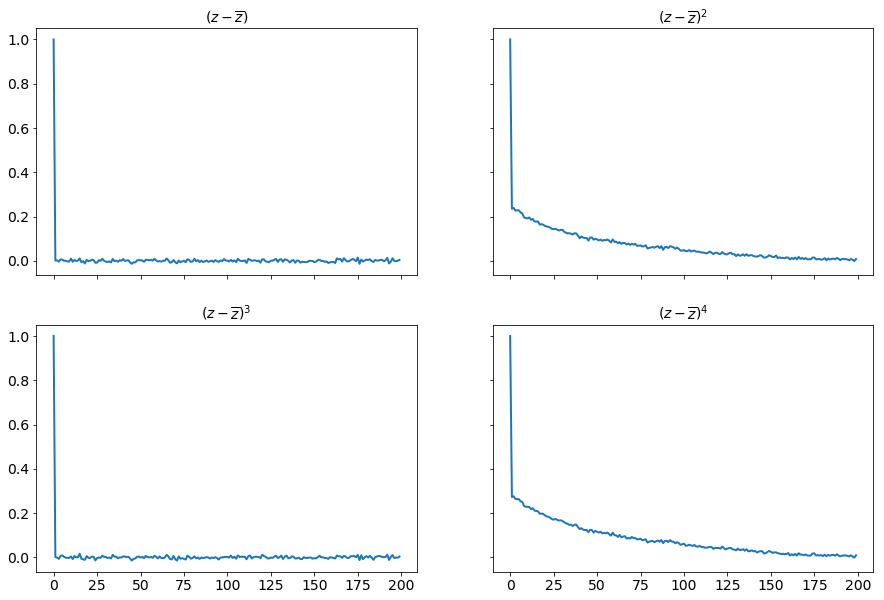

In [267]:
# Generate and plot correlograms
correlograms(zt)
plt.show()

There is still serial correlation in $(z -\overline{z})^2$ and $(z - \overline{z})^4$!

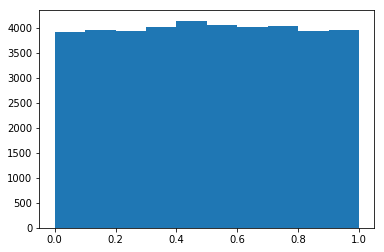

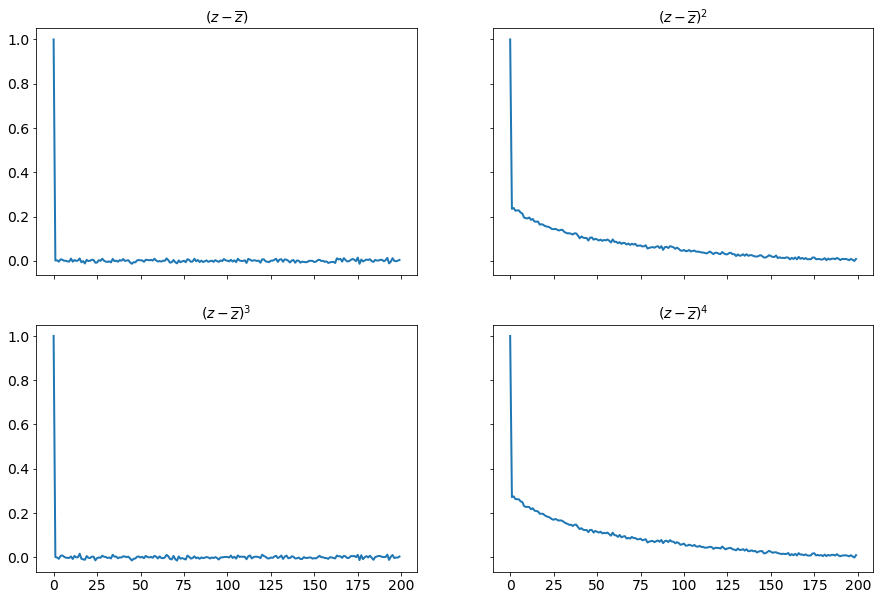

In [285]:
# update probability distribution every forecast -- not right still
ecdf = Cdf(insample)
zt = np.zeros(len(outsample))
for i, j in enumerate(outsample):
    zt[i] = ecdf.cdf(j)
    ecdf.update_cdf(j)
    
plt.hist(zt)
correlograms(zt)
plt.show()

The next two examples use the insample data in order to fit parameters to Gaussian and Student's t GARCH models. I don't have the toolbox to carry out those calculation, so I will not address those yet.

Let's look at a multivariate example that could apply to an LLC Membrane system. <br>
<br>
Suppose we are studying transport of a solute in a system in which we describe its position based on its $z$ coordinate and radial distance, $r$ from a membrane pore center.<br>
<br>
To generate data for instructive purposes, assume that the incremental $z$ positions come from a normal distribution and the $r$ positions come from a cauchy distribution.

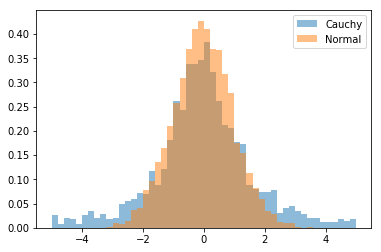

In [283]:
timesteps = 2000  
# every timestep a particle moves in the r direction based on a random draw from a cauchy 
# distribtuion and in the z direction according to a normal distribution

joint = np.zeros([timesteps, 2])  # [ntimesteps, (r, z)]
joint[:, 0] = np.random.standard_cauchy(size=timesteps) # r
joint[:, 1] = np.random.normal(size=timesteps) # z

plt.hist(joint[:, 0], bins=50, alpha=0.5, label='Cauchy', density=True, range=(-5, 5))
plt.hist(joint[:, 1], bins=50, alpha=0.5, label='Normal', density=True, range=(-5, 5))
plt.legend()
plt.show()